In [1]:
#load packages
from astLib.astStats import *
import mechanize
import cookielib
import httplib
from urllib2 import Request, urlopen, URLError
import os
import urllib
import numpy as np
import math as m
from scipy.stats import norm
import emcee
import scipy
from operator import itemgetter
import matplotlib.pyplot as plt
from scipy.integrate import quad
import warnings
import scipy.stats as ss
from astropy.time import Time
from scipy import interpolate

%matplotlib inline
import matplotlib

In [28]:
def findURL(source,ins):
###############################################################
# find URL to download public data from Swift/BAT transient
# monitor or MAXI online database. 
# NOTES: you can either hardwire in alternate source names in
#       the dictionaries below or use the command line prompt
#       to do so.
###############################################################
    sourceName=source.upper().replace('+','p').replace('-','m').replace(' ','')
    sourceN=source.upper().replace(' ','')
    if 'J' in sourceN:
        lower_space=sourceN.split('J')[0].lower().capitalize()+' J'+sourceN.split('J')[1]
        lower_nospace=sourceN.split('J')[0].lower().capitalize()+'J'+sourceN.split('J')[1]
        upper_space=sourceN.split('J')[0]+' J'+sourceN.split('J')[1]
    else:
        digit_list=[(i,c) for i,c in enumerate(sourceN) if c.isdigit()]
        digit_place=digit_list[0][0]
        lower_space=sourceN[0:digit_place].lower().capitalize()+' '+sourceN[digit_place:]
        lower_nospace=sourceN[0:digit_place].lower().capitalize()+sourceN[digit_place:]
        upper_space=sourceN[0:digit_place]+' '+sourceN[digit_place:]

    #optionally you can hardwire in the alternate names in these dictionaries
    if ins=='MAXI':
        dictionarySource={'SAXJ1819.3-2525':'V4641 Sgr','SWIFTJ1910.2-0546':'MAXI J1910-057','1A0620-00':'A 0620-00',
                        'SWIFTJ1357.2-0933':'Swift J1357.2-0933','4U0538-641':'LMC X-3','4U0540-697':'LMC X-1',
                        'SWIFTJ1753.5-0127':'SwiftJ1753.5-0127','4U1956+350':'Cyg X-1', 'SAX J1810.8-2609':'V4722 Sgr'}
    elif ins=='BAT':
        dictionarySource={'GS2000+251':'Ginga 2000+251','GS2023+338':'V404 Cyg','H1743-322':'IGR J17464-3213','1A1524-617':'TrA X-1',
                        '4U1543-475':'4U 1543-47','GRS1716-249':'Granat 1716-249','GS1124-684':'Nova Mus 1991','GS1354-64':'Ginga 1354-645',
                        'GRS1737-31':'AX J1740.1-3102','SWIFTJ174510.8-262411':'Swift J1745.1-2624','4U0538-641':'LMC X-3',
                        '4U0540-697':'LMC X-1','4U1956+350':'Cyg X-1','MAXIJ1631-479':'AX J1631.9-4752', 'SAX J1810.8-2609':'V4722 Sgr'}
    # Browser
    br = mechanize.Browser()
    
    # Cookie Jar
    cj = cookielib.LWPCookieJar()
    br.set_cookiejar(cj)
    
    # Browser options
    br.set_handle_equiv(True)
    br.set_handle_gzip(True)
    br.set_handle_redirect(True)
    br.set_handle_referer(True)
    br.set_handle_robots(False)
    
    # Follows refresh 0 but not hangs on refresh > 0
    br.set_handle_refresh(mechanize._http.HTTPRefreshProcessor(), max_time=1)
    
    # User-Agent (this is cheating, ok?)
    br.addheaders = [('User-agent', 'Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9.0.1) Gecko/2008071615 Fedora/3.0.1-1.fc9 Firefox/3.0.1')]

    # Open site
    if ins=='MAXI':
        url='http://maxi.riken.jp/top/slist.html'
        r = br.open(url)
        html = r.read()
        html_list=html.split('&#10004;</a></td></tr>')
        try:
            sourceNx=dictionarySource[sourceN]
            sourceN0=[sourceNx,lower_space,lower_nospace,upper_space]
        except KeyError:
            sourceN0=[lower_space,lower_nospace,upper_space]
        check=0
        for i in sourceN0:
            tempList=[x for x in html_list if i in x]
            if tempList!=[]:
                sourceN=i
                check=1
                break
            else:
                print 'Cannot Find '+i+' in MAXI Online Database ('+url+') ...'
                print 'Checking Other Known Alternate Names Now ...'
        if check==0:
            altNameCheck=raw_input('Do You Have Another Alternative Name? [N]: ')
            if altNameCheck=='Y' or altNameCheck=='y':
                altName=raw_input('Choose Alternate Name: ')
                print 'Checking User Input Alternate Name Now ...'
                tempList=[x for x in html_list if altName in x]
                if tempList==[]:
                    print 'Cannot Find '+altName+' in MAXI Online Database ('+url+') ...'
                    return ''
                else:
                    check=1
                    sourceN=altName
            else:
                print 'Cannot Find '+sourceN+' in MAXI Online Database ('+url+') ...'
                return ''
        if check==1:
            # Actually clicking the link
            print 'Found '+sourceN+' in MAXI Online Database ...'
            tempList=[x for x in html_list if sourceN in x]
            x0=tempList[0].split('<a href=')
            x1=x0[1].split('>&#10004;</a>')
            url_fin=x1[0].replace('"../','http://maxi.riken.jp/').replace('.html"','.html')
            r = br.open(url_fin)
            br.find_link(text='1day LC')
            req = br.click_link(text='1day LC')
            x=br.open(req)
            return br.geturl()

    elif ins=='BAT':
        dataLink=['ASCII version']
        url='http://swift.gsfc.nasa.gov/results/transients/'
        r = br.open(url)
        html = r.read()
        try:
            sourceNx=dictionarySource[sourceN]
            sourceN0=[sourceNx,lower_space,lower_nospace,upper_space]
        except KeyError:
            sourceN0=[lower_space,lower_nospace,upper_space]
        check=0
        for x in sourceN0:
            try:
                br.find_link(text=x)
                sourceN=x
                check=1
                print 'Found '+sourceN+' in BAT Online Database ...'
                break
            except mechanize.LinkNotFoundError:
                print 'Cannot Find '+x+' in BAT Online Database ('+url+') ...'
                print 'Checking Other Known Alternate Names Now ...'
        if check==0:
            altNameCheck=raw_input('Do You Have Another Alternative Name? [N]: ')
            if altNameCheck=='Y' or altNameCheck=='y':
                altName=raw_input('Choose Alternate Name: ')
                print 'Checking User Input Alternate Name Now ...'
                try:
                    br.find_link(text=altName)
                    sourceN=altName
                    check=1
                    print 'Found '+sourceN+' in BAT Online Database ...'
                except mechanize.LinkNotFoundError:
                    print 'Cannot Find '+altName+' in BAT Online Database ('+url+') ...'
                    return ''
            else:
                return ''
        if check==1:
            # Actually clicking the link
            try:
                req = br.click_link(text=sourceN)
                x=br.open(req)
                br.geturl()
                for item in dataLink:
                    br.find_link(text=item)
                    req2=br.click_link(text=item)
                    br.open(req2)
                    return br.geturl()
            except mechanize.LinkNotFoundError:
                return ''

def DownloadData(source,ins):
######################################################################
# download data from BAT or MAXI online public data catalogues.
# INPUTS:
#        source = source name
#        ins = instrument ('BAT' or 'MAXI')
# NOTES: downloads and writes ascii lc file as: sourceName_ins_lc.txt
#        in the ./ins+Obs/sourceName directory. If the ascii lc file 
#        already exists, new data will be added to it.
######################################################################
    #urlname=findURL(source,ins)
    if ins == 'MAXI':
        urlname = 'http://maxi.riken.jp/star_data/J1911+005/J1911+005_g_lc_1day_all.dat'
    else:
        urlname = 'https://swift.gsfc.nasa.gov/results/transients/AqlX-1.lc.txt'
    sourceName=source.upper().replace('+','p').replace('-','m').replace(' ','')
    print 'Downloading All '+ins+' Data Available For '+source.upper().replace(' ','')
    mypath='./'+ins+'Obs/'+sourceName
    try:
        os.makedirs(mypath)
    except OSError:
        pass
    filename=mypath+'/'+sourceName+'_'+ins+'_lc.txt'
    if not urlname=='':
        if os.path.isfile(filename):
            with open(filename) as f:
                lines=f.readlines()
            lines=[x if '\n' in x else x+'\n' for x in lines]
            basename,ext=os.path.splitext(filename)
            savefile=basename+'.sav'
            os.rename(filename,savefile)
            f2=np.loadtxt(savefile,usecols=(0,))
            max_line=len(f2)
            file2=open(filename,'w')
            file2.writelines(lines)
        else:
            file2=open(filename,'w')
            max_line=0
        iterate=1
        while iterate<5:
            try:
                f=urllib.urlopen(urlname)
                iterate=5
            except IOError, e:
                if e.errno == 101:
                    print 'Network Error, Connection Attempt '+str(iterate)+', Trying Again ...'
                    time.sleep(1)
                    iterate=iterate+1
        if max_line!=0:
            lines_list=f.readlines()[max_line:]
            for line in lines_list:
                file2.write(line)
        else:
            if iterate<=5:
                file2.write(f.read())
            else:
                print 'Network Error, Download of '+sourceName+' Data From'
                print urlname+' failed.' 
                print 'No New Data Was Downloaded on This Source.'
        file2.close()
    else:
        print 'No Data For '+sourceName+' Found in '+ins+' Online Database ('+urlname+') ...'
        print 'No Data Was Downloaded on This Source.'
        file2=open(filename,'w')
        file2.close()

In [29]:
#this is an example run for GX339-4

#####################
# EDIT THIS:
source1='AqlX1'#choose source name
####################

In [30]:
# step 1: download current BAT and MAXI/GSC light-curves
DownloadData(source1,'MAXI')
DownloadData(source1,'BAT')

In [31]:
def LineCount(file_name):
########################################
# returns the number of lines in a file
# INPUTS:
#        file_name = name of file
#######################################
    count=0
    for j in open(file_name):
        count=count+1   
    return count

def errorCorrection(source,ins):
###################################################
# perform background subtraction and corrects the 
# underestimated quoted uncertainties in the BAT
# and MAXI ASM survey light-curves. Outputs the
# following files of cleaned data in count rate
# and crab units in the ./ins+Obs/sourceName 
# directory:
# sourceName_ins_lc_eband.txt
# sourceName_ins_lc_eband_crab.txt
# INPUTS:
#        source = source name
#        ins = instrument ('BAT' or 'MAXI')
##################################################
    sourceName=source.upper().replace('+','p').replace('-','m').replace(' ','')
    print 'Performing Uncertainty Correction on '+ins+' Data Available for: '+source.upper().replace(' ','')
    mypath='./'+ins+'Obs/'+sourceName
    filename=mypath+'/'+sourceName+'_'+ins+'_lc.txt'
    if ins=='MAXI':
        tcol=0
        rcol=5
        ecol=6
        crabConv=1.24
        eband='4_10'
        skipr=0
    elif ins=='BAT':
        tcol=0
        rcol=1
        ecol=2
        crabConv=0.22 
        eband='15_50'   
        skipr=5 
    if os.path.isfile(filename):
        if LineCount(filename)>0.0:
            array=np.loadtxt(filename,skiprows=skipr)
            fileA=open(filename.replace('.txt','_biw.txt'),'w')
            c_values=[array[i][rcol] for i in range(0,len(array),1) if array[i][ecol]!=0]
            dictBIW=biweightClipped(c_values,6.0,3.0)      
            sig_level=3
            biw=dictBIW['biweightLocation']
            biw_e=dictBIW['biweightScale']
            for j in range(0,len(array),1):
                if not array[j][ecol]==0:
                    biw_err=m.sqrt((biw_e*biw_e)+(array[j][ecol]*array[j][ecol]))
                    dev=(array[j][rcol]-biw)/(biw_err)
                    if abs(array[j][rcol])<biw+(sig_level*array[j][ecol]):
                        fileA.write('{0} {1}\n'.format(array[j][tcol],dev))
            fileA.close()
            if LineCount(filename.replace('.txt','_biw.txt'))>1:
                h_data=np.loadtxt(filename.replace('.txt','_biw.txt'))
                (mu,sigma)=norm.fit(h_data[:,1])
            else:
                mu,sigma=0.0,1.0
            fileB=open(filename.replace('.txt','_'+eband+'.txt'),'w')
            fileC=open(filename.replace('.txt','_'+eband+'_crab.txt'),'w')
            array=np.loadtxt(filename,skiprows=skipr)
            for i in range(0,len(array),1):
                fileB.write('{0} {1} {2}\n'.format(array[i][tcol],array[i][rcol],array[i][ecol]*sigma))
                fileC.write('{0} {1} {2}\n'.format(array[i][tcol],array[i][rcol]/crabConv,array[i][ecol]*sigma/crabConv))
            fileB.close()
            fileC.close()
            print 'Uncertainty Correction on '+ins+' Data ... Complete'
        else:
            fileA=open(filename.replace('.txt','_biw.txt'),'w')
            fileB=open(filename.replace('.txt','_'+eband+'.txt'),'w')
            fileC=open(filename.replace('.txt','_'+eband+'_crab.txt'),'w')
            fileA.close()
            fileB.close()
            fileC.close()
    else:
        print 'No '+ins+' Data Available for '+sourceName.replace('p','+').replace('m','-')
        print 'Uncertainty Correction on '+ins+' Data ... Complete'

In [32]:
# step 2: WATCHDOG pipeline data cleaning
errorCorrection(source1,'MAXI')
errorCorrection(source1,'BAT')

Performing Uncertainty Correction on MAXI Data Available for: AQLX1
Uncertainty Correction on MAXI Data ... Complete
Performing Uncertainty Correction on BAT Data Available for: AQLX1
Uncertainty Correction on BAT Data ... Complete


In [33]:
def dataDetect(source,ins,eband):
########################################################
# runs cleaned ascii light-curves through the WATCHDOG
# detection algorithm and returns new data files with
# a detection/non-detection flag in the 
# ./ins+Obs/sourceName directory:
# sourceName_ins_lc_eband_det.txt
# sourceName_ins_lc_eband_crab_det.txt 
# INPUTS:
#        source = source name
#        ins = instrument ('BAT' or 'MAXI')
#        eband = energy band of light-curve
########################################################
    sourceName=source.upper().replace('+','p').replace('-','m').replace(' ','')
    print 'Running '+ins+' Data Available for '+source.upper().replace(' ','')+' \nThrough WATCHDOG Outburst Detection Algorithm ...'
    mypath='./'+ins+'Obs/'+sourceName
    filename=mypath+'/'+sourceName+'_'+ins+'_lc.txt'
    filenames=[filename.replace('.txt','_'+eband+'.txt'),filename.replace('.txt','_'+eband+'_crab.txt')]
    for f in filenames:
        array=np.loadtxt(f)
        length=LineCount(f)
        sig_level=3
        if length>1:
            time=array[:,0]
            rate=array[:,1]
            err=array[:,2]
        elif length==1:
            time=np.array([array[0]])
            rate=np.array([array[1]])
            err=np.array([array[2]])
        else:
            time=np.array([])
            rate=np.array([])
            err=np.array([])
        c_values=[]
        for i in range(0,len(time),1):
            if ins=='MAXI':
                if (time[i]>=55074.0 and time[i]<=55082.0) or (time[i]>=55153.0 and time[i]<=55160.0) or (time[i]>=55237.0 and time[i]<=55247.0):
                    continue
                else:
                    c_values.append(rate[i])
            else:
                c_values.append(rate[i])    
        dictBIW=biweightClipped(c_values,6.0,3.0)
        biw=dictBIW['biweightLocation']
        biw_e=dictBIW['biweightScale']
        filex=open(f.replace('.txt','_det.txt'),'w')
        for j in range(0,len(time),1):
            if ins=='MAXI':
                if (time[i]>=55074.0 and time[i]<=55082.0) or (time[i]>=55153.0 and time[i]<=55160.0) or (time[i]>=55237.0 and time[i]<=55247.0):
                    continue
                else:
                    if rate[j]<biw+(sig_level*err[j]):
                        det_flag=0
                    elif rate[j]>=biw+(sig_level*err[j]) and rate[j]>0.0:
                        det_flag=1
                    filex.write('{0}  {1}  {2}  {3}\n'.format(time[j],rate[j],err[j],det_flag))
            else:
                if rate[j]<biw+(sig_level*err[j]):
                    det_flag=0
                elif rate[j]>=biw+(sig_level*err[j]) and rate[j]>0.0:
                    det_flag=1
                filex.write('{0}  {1}  {2}  {3}\n'.format(time[j],rate[j],err[j],det_flag))
        filex.close()
    print 'Outburst Detection Algorithm for '+ins+' Data ... Complete'

In [34]:
# step 3: WATCHDOG pipeline outburst detection algorithm
dataDetect(source1,'MAXI','4_10')
dataDetect(source1,'BAT','15_50')

Running MAXI Data Available for AQLX1 
Through WATCHDOG Outburst Detection Algorithm ...
Outburst Detection Algorithm for MAXI Data ... Complete
Running BAT Data Available for AQLX1 
Through WATCHDOG Outburst Detection Algorithm ...
Outburst Detection Algorithm for BAT Data ... Complete


In [35]:
def timeCompareData(source):
######################################################
# time match BAT and MAXI data. outputs the following 
# asciii data file in the HardnessRatioData directory:
# ./sourceName/sourceName_rate_data_SM.txt
# INPUTS:
#        source = source name
# NOTES: the output data file will be used in the
#        calculateHR function
######################################################
    print 'Performing a Time Match on BAT and MAXI Data ...'
    sourceName=source.upper().replace('+','p').replace('-','m').replace(' ','')
    try:
        os.makedirs('./HardnessRatioData/'+sourceName)
    except OSError:
        pass
    fileBAT='./BATObs/'+sourceName+'/'+sourceName+'_BAT_lc_15_50_crab_det.txt'
    fileMAXI='./MAXIObs/'+sourceName+'/'+sourceName+'_MAXI_lc_4_10_crab_det.txt'
    filew=open('./HardnessRatioData/'+sourceName+'/'+sourceName+'_rate_data_SM.txt','w')
    if os.path.isfile(fileBAT) and os.path.isfile(fileMAXI):
        dataBAT=np.loadtxt(fileBAT)
        dataMAXI=np.loadtxt(fileMAXI)
        time_check=[]
        for i in range(0,len(dataBAT),1):
            timeBAT=dataBAT[i][0]
            for j in range(0,len(dataMAXI),1):
                timeMAXI=dataMAXI[j][0]
                if int(timeBAT)==int(timeMAXI):
                    if timeBAT not in time_check and dataBAT[i][1]>0.0 and dataMAXI[j][1]>0.0:
                        filew.write('{0}  {1}  {2}  {3}  {4} {5} {6}\n'.format(timeBAT,dataBAT[i][1],dataBAT[i][2],dataMAXI[j][1],dataMAXI[j][2],dataBAT[i][3],dataMAXI[j][3]))
                        time_check.append(timeBAT)
    else:
        print 'BAT and/or MAXI Data are Not Available for '+sourceName.replace('p','+').replace('m','-')
    filew.close()
    print 'Time Match BAT and MAXI Data ... Complete'

def logprob(p,x,y,x_err,y_err):
##############################################################
# log probability for theta parametrization of hardness ratio
# INPUTS:
#        p = parameter array
#        x,y = data vectors of soft and hard band count rates
#        x_err,y_err = data vectors of uncertainty in soft 
#                      and hard band count rates
#############################################################
    theta = p[0]
    if np.abs(theta-np.pi/4)>np.pi/4:
        return -np.inf
    Delta = (np.cos(theta)*y - np.sin(theta)*x)**2
    Sigma = (np.sin(theta))**2*x_err**2+(np.cos(theta))**2*y_err**2
    lp = -0.5*np.nansum(Delta/Sigma)-0.5*np.nansum(np.log(Sigma))

    return lp

def BayesRatio(x,y,x_err,y_err,nWalkers=10,nBurn=100,nSample=1000):
###################################################################
# calculates pdf of hardness ratio via theta parametrization and a 
# MCMC method. Outputs a numpy array of samples of the ratio 
# of the data
# INPUT:
#       x,y = data vectors of soft and hard band count rates
#       x_err,y_err = data vectors of uncertainty in soft 
#                     and hard band count rates
#       nWalkers = 10 (default), number of walkers in the sampler
#                  (>2 required)
#       nBurn = 100 (default), number of steps to burn in chain
#       nSample = 1000 (default), number of steps to sample chain
###################################################################
    ndim = 1
    p0 = np.zeros((nWalkers,ndim))
    p0[:,0] = np.pi/4+np.random.randn(nWalkers)*0.1

    sampler = emcee.EnsembleSampler(nWalkers, ndim, logprob, 
                                    args=[x,y,x_err,y_err])
    pos, prob, state = sampler.run_mcmc(p0, nBurn)
    sampler.reset()
    sampler.run_mcmc(pos, nSample)
    return(np.tan(sampler.flatchain))

def calculateHR(source,optionf=''):
############################################################
# WATCHDOG MCMC algorithm to compute hardness ratio
# INPUTS:
#        source = source name
#        optionf = choose to compute HRs taking into account 
#                  detections in BAT and MAXI bands by 
#                  computing upper (detection BAT/non-detection
#                  MAXI) and lower (non-detection BAT/detection 
#                  MAXI) limits when appropriate (''; default) or 
#                  compute HRs on all days regardless of detection 
#                  ('all')
# NOTES: HR data, as well as pdfs of HRs for each day are 
#        written to the HardnessRatioData directory as:
#            - ./sourceName/sourceName_HR_data_SM.txt
#            - ./sourceName/pdfs/sourceName_[time_mjd].txt
#        if HR data already exists, the ascii data file will
#        be updated with new data
############################################################
    print 'Computing Hardness Ratio with BAT and MAXI Data ...'
    sourceName=source.upper().replace('+','p').replace('-','m').replace(' ','')
    try:
        os.makedirs('./HardnessRatioData/'+sourceName+'/pdfs')
    except OSError:
        pass 
    if optionf=='all':
        filename='./HardnessRatioData/'+sourceName+'/'+sourceName+'_HR_data_SM_all.txt'

    else:
        filename='./HardnessRatioData/'+sourceName+'/'+sourceName+'_HR_data_SM.txt'

    if os.path.isfile(filename):
        with open(filename) as f:
            lines=f.readlines()
        lines=[x if '\n' in x else x+'\n' for x in lines]
        basename,ext=os.path.splitext(filename)
        savefile=basename+'.sav'
        os.rename(filename,savefile)
        if LineCount(savefile)==1:
            f2a=np.loadtxt(savefile)
            f2=[]
            f2.append(f2a[0])
        else:
            f2=np.loadtxt(savefile,usecols=(0,))
        if len(f2)==0:
            max_t=0
        else:
            max_t=max(f2)
        filewrite1b=open(filename,'w')
        filewrite1b.writelines(lines)
    else:
        filewrite1b=open(filename,'w')
        max_t=0

    filename2='./HardnessRatioData/'+sourceName+'/'+sourceName+'_rate_data_SM.txt'
    rate_values=np.loadtxt(filename2)
    if LineCount(filename2)>1:
        time=rate_values[:,0]
        R_H=rate_values[:,1]
        R_S=rate_values[:,3]
        errH=rate_values[:,2]
        errS=rate_values[:,4]
        detH=rate_values[:,5]
        detS=rate_values[:,6]
    elif LineCount(filename2)==1:
        time=np.array([rate_values[0]])
        R_H=np.array([rate_values[1]])
        R_S=np.array([rate_values[3]])
        errH=np.array([rate_values[2]])
        errS=np.array([rate_values[4]])
        detH=np.array([rate_values[5]])
        detS=np.array([rate_values[6]])
    else:
        filewrite1b.close()
        print 'Insufficent Data Exists to Compute Hardness Ratios in '+sourceName.replace('p','+').replace('m','-')
        return


    dictBIW1=biweightClipped(errH,6.0,3.0)
    dictBIW2=biweightClipped(errS,6.0,3.0)
    mean_1=dictBIW1['biweightLocation']
    std_1=dictBIW1['biweightScale']
    mean_2=dictBIW2['biweightLocation']
    std_2=dictBIW2['biweightScale']

    for ind in range(0,len(time),1):
        if time[ind]>max_t:
            samples=BayesRatio(R_S[ind],R_H[ind],errS[ind],errH[ind],nWalkers=10,nBurn=100,nSample=1000)
            samplesSort=np.sort(samples,axis=None) 
            file_pdf=open('./HardnessRatioData/'+sourceName+'/pdfs/'+sourceName+'_'+str(time[ind])+'.txt','w')
            for item in samplesSort:
                file_pdf.write("%s\n" % item)
            file_pdf.close()
            med=np.median(samplesSort)
            gaussCDF=norm.cdf(1)
            N=len(samplesSort)
            x=[i for i in xrange(N)]
            high_lim_i=gaussCDF*N
            low_lim_i=(1-gaussCDF)*N            
            y_interp=scipy.interpolate.interp1d(x,samplesSort,bounds_error=True)
            high_lim=np.float128(y_interp(high_lim_i))
            low_lim=np.float128(y_interp(low_lim_i))
            if detH[ind]==1.0 and detS[ind]==1.0:
                det_string='11'
                filewrite1b.write('{0}  {1}  {2}  {3}  {4}  {5}  {6}  {7} {8}\n'.format(time[ind],R_H[ind],errH[ind],R_S[ind],
                                errS[ind],med,low_lim,high_lim,det_string)) 
            elif detH[ind]==1.0 and detS[ind]==0.0:
                det_string='10'
                if errS[ind]<mean_2+(2.0*std_2):
                    low_lim=med # Changed this from high lim -- 01-18
                    filewrite1b.write('{0}  {1}  {2}  {3}  {4}  {5}  {6}  {7} {8}\n'.format(time[ind],R_H[ind],errH[ind],R_S[ind],
                                errS[ind],med,low_lim,high_lim,det_string)) 
            elif detH[ind]==0.0 and detS[ind]==1.0:
                det_string='01'
                if errH[ind]<mean_1+(2.0*std_1):
                    high_lim=med # Changed this from low lim -- 01-18
                    filewrite1b.write('{0}  {1}  {2}  {3}  {4}  {5}  {6}  {7} {8}\n'.format(time[ind],R_H[ind],errH[ind],R_S[ind],
                                errS[ind],med,low_lim,high_lim,det_string)) 
            elif detH[ind]==0.0 and detS[ind]==0.0:
                det_string='00'
                if optionf=='all':
                    if errS[ind]<mean_2+(2.0*std_2) and errH[ind]<mean_1+(2.0*std_1):
                        filewrite1b.write('{0}  {1}  {2}  {3}  {4}  {5}  {6}  {7} {8}\n'.format(time[ind],R_H[ind],errH[ind],R_S[ind],
                                        errS[ind],med,low_lim,high_lim,det_string)) 
       
    filewrite1b.close()
    print 'Hardness RatiComputation ... Complete'

In [49]:
# step 4: WATCHDOG pipeline hardness ratio computation: BAT[15-50 keV]/MAXI[4-10 keV]
timeCompareData(source1)
#calculateHR(source1,'')
calculateHR(source1,'all')

Performing a Time Match on BAT and MAXI Data ...
Time Match BAT and MAXI Data ... Complete
Computing Hardness Ratio with BAT and MAXI Data ...
Hardness RatiComputation ... Complete


In [37]:
def stateDef(low,high,hname):
############################################################
# fetches the calibrated HR hard and soft state limits
# computed with the WATCHDOG pipeline and uses them to
# determine the accretion state of the source
# INPUTS: 
#        low = lower limit of HR
#        high = upper limit of HR
#        hname = HR flag
# NOTES: requires the calibration_values_WATCHDOG.txt file
############################################################
    file1=open('./DataFiles/calibration_values_WATCHDOG.txt','rb')
    table=[row.strip().split(' ') for row in file1 if hname in row]
    file1.close()
    FormatHcal="%.10f" % float(table[0][4])
    FormatScal="%.10f" % float(table[0][2])
    if float(low)>=float(FormatHcal):
        state=1
    elif float(high)<=float(FormatScal):   
        state=0
    else:
        state=2
    return(state,float(FormatHcal),float(FormatScal))

def AccretionStateClassification(source,h='SM',optionf=''):
############################################################
# use the WATCHDOG Accretion-State-By-Day tool to determine
# daily accretion state information and writes out to the
# following data file in the HardnessRatioData directory:
# ./sourceName/sourceName_state_data.txt
# INPUTS:
#        source = source name
#        h = HR flag (default SM)
#        optionf = choose to compute HRs taking into account 
#                  detections in BAT and MAXI bands by 
#                  computing upper (detection BAT/non-detection
#                  MAXI) and lower (non-detection BAT/detection 
#                  MAXI) limits when appropriate (''; default) or 
#                  compute HRs on all days regardless of detection 
#                  ('all')
# NOTES: the value of optionf should be the same as chosen
#        in calculateHR
############################################################
    sourceName=source.upper().replace('+','p').replace('-','m').replace(' ','')
    print 'Performing Accretion State Classification on '+sourceName.replace('p','+').replace('m','-')+'\nWith the WATCHDOG Accretion-State-By-Day tool ...'
    if optionf=='all':
        filename='./HardnessRatioData/'+sourceName+'/'+sourceName+'_HR_data_SM_all.txt'
        outfile='./HardnessRatioData/'+sourceName+'/'+sourceName+'_state_data_all.txt'
    else:
        filename='./HardnessRatioData/'+sourceName+'/'+sourceName+'_HR_data_SM.txt'
        outfile='./HardnessRatioData/'+sourceName+'/'+sourceName+'_state_data.txt'

    fout=open(outfile,'w')
    hr_ratio=np.loadtxt(filename)
    if LineCount(filename)>0.0:
        time=hr_ratio[:,0]
        rateH=hr_ratio[:,1]
        rateHerr=hr_ratio[:,2]
        rateS=hr_ratio[:,3]
        rateSerr=hr_ratio[:,4]
        HR=hr_ratio[:,5]
        HR_low=hr_ratio[:,6]
        HR_high=hr_ratio[:,7] 
        HR_flag=hr_ratio[:,8] 

        for i in range(0,len(time),1):
            highFormatted='%.10f' % HR_high[i]
            lowFormatted='%.10f' % HR_low[i]
            flag_h=str(int(HR_flag[i]))
            st,hcal,scal=stateDef(lowFormatted,highFormatted,h)
            if flag_h=='1':
                flag_h='01'
            if flag_h=='0':
                flag_h='00'
            fout.write('{0} {1} {2}\n'.format(time[i],st,flag_h))
    fout.close()
    print 'Accretion State Classification on '+sourceName.replace('p','+').replace('m','-')+' ... Complete'

In [50]:
# step 5: WATCHDOG pipeline accretion state classification
AccretionStateClassification(source1,'SM','all')

Performing Accretion State Classification on AQLX1
With the WATCHDOG Accretion-State-By-Day tool ...
Accretion State Classification on AQLX1 ... Complete


In [39]:
def plot_data(source,time_list,line_opt=False,h='SM',optionf=''):
######################################################
# plot figure including light-curves and HID making
# use of Swift/BAT and MAXI/GSC public data
# INPUT:
#       source = source name
#       time_list = list in form [tb,te] defining
#                   start (tb) and end (te) MJD
#                   for the outburst
#       line_opt = connect HID data with dashed line,
#                  default is False
#       h = HR flag (default SM)
######################################################
    sourceName=source.upper().replace('+','p').replace('-','m').replace(' ','')
    data_file='./HardnessRatioData/'+sourceName+'/'+sourceName+'_HR_data_'+str(h) + optionf + '.txt'
    tb,te=time_list[0],time_list[1]
    
    mypath='./Figs/'+sourceName
    try:
        os.makedirs(mypath)
    except OSError:
        pass

    watchdog_state=np.loadtxt('./HardnessRatioData/'+sourceName+'/'+sourceName+'_state_data' + optionf + '.txt' ,usecols=(0,1))    
    w_time=watchdog_state[:,0]
    w_state=watchdog_state[:,1]

    dataA=np.loadtxt(data_file)
    time=dataA[:,0]
    RH=dataA[:,1]
    RS=dataA[:,3]
    EH=dataA[:,2]
    ES=dataA[:,4]
    H=dataA[:,5]
    Hlow=dataA[:,5]-dataA[:,6]
    Hhigh=dataA[:,7]-dataA[:,5]
    HR_flag=dataA[:,8]
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams['text.latex.preamble'] = [r'\boldmath']            
    fig = plt.figure()
    fig.set_size_inches(24,12)
    ax1 = plt.subplot2grid((6,9), (0,0), colspan=4, rowspan=2)
    ax2 = plt.subplot2grid((6,9), (2,0), colspan=4,rowspan=2, sharex=ax1)
    ax3 = plt.subplot2grid((6,9), (4,0), colspan=4,rowspan=2, sharex=ax2)
    ax4 = plt.subplot2grid((6,9), (0,4), colspan=5,rowspan=6)

    fig.subplots_adjust(hspace=0.1,wspace=0.8)
    plt.setp(ax1.get_xticklabels(),visible=False)
    plt.setp(ax2.get_xticklabels(),visible=False) 
    
    state2='none'
    hardness=[]
    rate=[]
    newtime=[]
    idx=np.where(np.logical_and(time>=tb, time<=te))
    out_times=time[idx]
    time_low=np.amin(out_times)
    time_high=np.amax(out_times)
    for i in range(0,len(time),1):
        if time[i]>=tb and time[i]<=te:
            for j in range(0,len(w_time),1):
                if int(time[i])==int(w_time[j]):
                    state2=w_state[j]
                    break
            if state2==1:
                col='#68C4F9'
            elif state2==2:
                col='#FFF14C'
            elif state2==0:
                col='#F96868'
            else:
                col='grey'
            if RH[i]>RS[i]:
                Rmax=RH[i]
                Rerr=EH[i]
            else:
                Rmax=RS[i]
                Rerr=ES[i] 
            if int(time[i])==int(time_low):
                if Hlow[i]==0.0:
                    ax4.errorbar([H[i]],[Rmax],yerr=[Rerr],xerr=[[Hlow[i]],[Hhigh[i]]],color='#38F775',fmt='*',mec='k',
                                elinewidth=1,ecolor='grey',markersize=30,zorder=10,markeredgewidth=2,
                                xlolims=np.array([1]),label='Start')
                elif Hhigh[i]==0.0:
                    ax4.errorbar([H[i]],[Rmax],yerr=[Rerr],xerr=[[Hlow[i]],[Hhigh[i]]],color='#38F775',fmt='*',mec='k',
                                elinewidth=1,ecolor='grey',markersize=30,zorder=10,markeredgewidth=2,
                                xuplims=np.array([1]),label='Start')
                else:
                    ax4.errorbar([H[i]],[Rmax],yerr=[Rerr],xerr=[[Hlow[i]],[Hhigh[i]]],color='#38F775',fmt='*',mec='k',
                                elinewidth=1,ecolor='grey',markersize=30,zorder=10,markeredgewidth=2,label='Start')
            elif int(time[i])==int(time_high):
                if Hlow[i]==0.0:
                    ax4.errorbar([H[i]],[Rmax],yerr=[Rerr],xerr=[[Hlow[i]],[Hhigh[i]]],color='#B67EF5',fmt='*',mec='k',
                                elinewidth=1,ecolor='grey',markersize=30,zorder=10,markeredgewidth=2,
                                xlolims=np.array([1]),label='Stop')
                elif Hhigh[i]==0.0:
                    ax4.errorbar([H[i]],[Rmax],yerr=[Rerr],xerr=[[Hlow[i]],[Hhigh[i]]],color='#B67EF5',fmt='*',mec='k',
                                elinewidth=1,ecolor='grey',markersize=30,zorder=10,markeredgewidth=2,
                                xuplims=np.array([1]),label='Stop')
                else:
                    ax4.errorbar([H[i]],[Rmax],yerr=[Rerr],xerr=[[Hlow[i]],[Hhigh[i]]],color='#B67EF5',fmt='*',mec='k',
                                elinewidth=1,ecolor='grey',markersize=30,zorder=10,markeredgewidth=2,label='Stop')
            else:
                if Hlow[i]==0.0:
                    ax4.errorbar([H[i]],[Rmax],yerr=[Rerr],xerr=[[Hlow[i]],[Hhigh[i]]],color=col,fmt='o',mec='k',
                                elinewidth=1,ecolor='grey',markersize=10,xlolims=np.array([1]))
                elif Hhigh[i]==0.0:
                    ax4.errorbar([H[i]],[Rmax],yerr=[Rerr],xerr=[[Hlow[i]],[Hhigh[i]]],color=col,fmt='o',mec='k',
                                elinewidth=1,ecolor='grey',markersize=10,xuplims=np.array([1]))
                else:
                    ax4.errorbar([H[i]],[Rmax],yerr=[Rerr],xerr=[[Hlow[i]],[Hhigh[i]]],color=col,fmt='o',mec='k',
                                elinewidth=1,ecolor='grey',markersize=10)
                
            ax1.errorbar([time[i]],[RH[i]],yerr=[EH[i]],color=col,fmt='o',mec='k',elinewidth=1,ecolor='grey',
                         markersize=8)  
            ax2.errorbar([time[i]],[RS[i]],yerr=[ES[i]],color=col,fmt='o',mec='k',elinewidth=1,ecolor='grey',
                         markersize=8) 
            ax3.errorbar([time[i]],[H[i]],yerr=[[Hlow[i]],[Hhigh[i]]],color=col,fmt='o',mec='k',elinewidth=1,
                         ecolor='grey',markersize=8) 
                
            hardness.append(H[i])
            rate.append(Rmax)
            newtime.append(time[i])
            
    ind=np.array(sorted(range(len(newtime)), key=lambda k: newtime[k])) 
    ind=np.array(ind)
    hardness=np.array(hardness)
    rate=np.array(rate)
    if line_opt==True:
        ax4.plot(hardness[ind],rate[ind],linestyle='--',linewidth=2,color='#E7E9EA')
    
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax1.tick_params(axis='both', which='major', length=10,width=1.5)
    ax1.tick_params(axis='both', which='minor', length=4.5,width=1.5)
    ax1.tick_params(axis='both', which='both',direction='in',right='on',top='on')
    ax1.set_yscale("log",nonposy='clip')
    ax1.minorticks_on()

    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='both', which='major', length=10,width=1.5)
    ax2.tick_params(axis='both', which='minor', length=4.5,width=1.5)
    ax2.tick_params(axis='both', which='both',direction='in',right='on',top='on')
    ax2.set_yscale("log",nonposy='clip')
    ax2.minorticks_on()

    ax3.tick_params(axis='both', which='major', labelsize=20)
    ax3.tick_params(axis='both', which='major', length=10,width=1.5)
    ax3.tick_params(axis='both', which='minor', length=4.5,width=1.5)
    ax3.tick_params(axis='both', which='both',direction='in',right='on',top='on')
    ax3.set_yscale("log",nonposy='clip')
    ax3.minorticks_on()
        
    ax4.tick_params(axis='both', which='major', labelsize=25)
    ax4.tick_params(axis='both', which='major', length=10,width=1.5)
    ax4.tick_params(axis='both', which='minor', length=4.5,width=1.5)
    ax4.tick_params(axis='both', which='both',direction='in',right='on',top='on')
    ax4.tick_params(axis='x')
    ax4.tick_params(axis='y')
    ax4.set_yscale("log",nonposy='clip')
    ax4.set_xscale("log",nonposx='clip')
    ax4.minorticks_on()
    
    ax4.legend(loc=2,numpoints=1,ncol=2,markerscale=1.,fontsize=20)


    ax1.set_ylabel(r'${\rm Swift/BAT}$'+'\n'+r'${\rm [15-50\, keV]}$',fontsize=20)
    ax2.set_ylabel(r'${\rm MAXI/GSC}$'+'\n'+r'${\rm [4-10\, keV]}$',fontsize=20)
    ax3.set_ylabel(r'${\rm Hardness \, Ratio}$',fontsize=20)
    ax3.set_xlabel(r'${\rm MJD}$',fontsize=20)
    ax4.set_ylabel(r'${\rm Count\, Rate \, (crabs)}$',fontsize=25)
    ax4.set_xlabel(r'${\rm Hardness \, Ratio}$'+'\n'+r'${\rm [15-50\, keV]/[4-10\, keV]}$',fontsize=25)

    fig.subplots_adjust(hspace=0.1,wspace=2.0)
    plt.savefig('./Figs/'+sourceName+'/'+sourceName+'_HID_'+str(tb)+'_'+str(te)+'.pdf',bbox_inches='tight')
    plt.show()

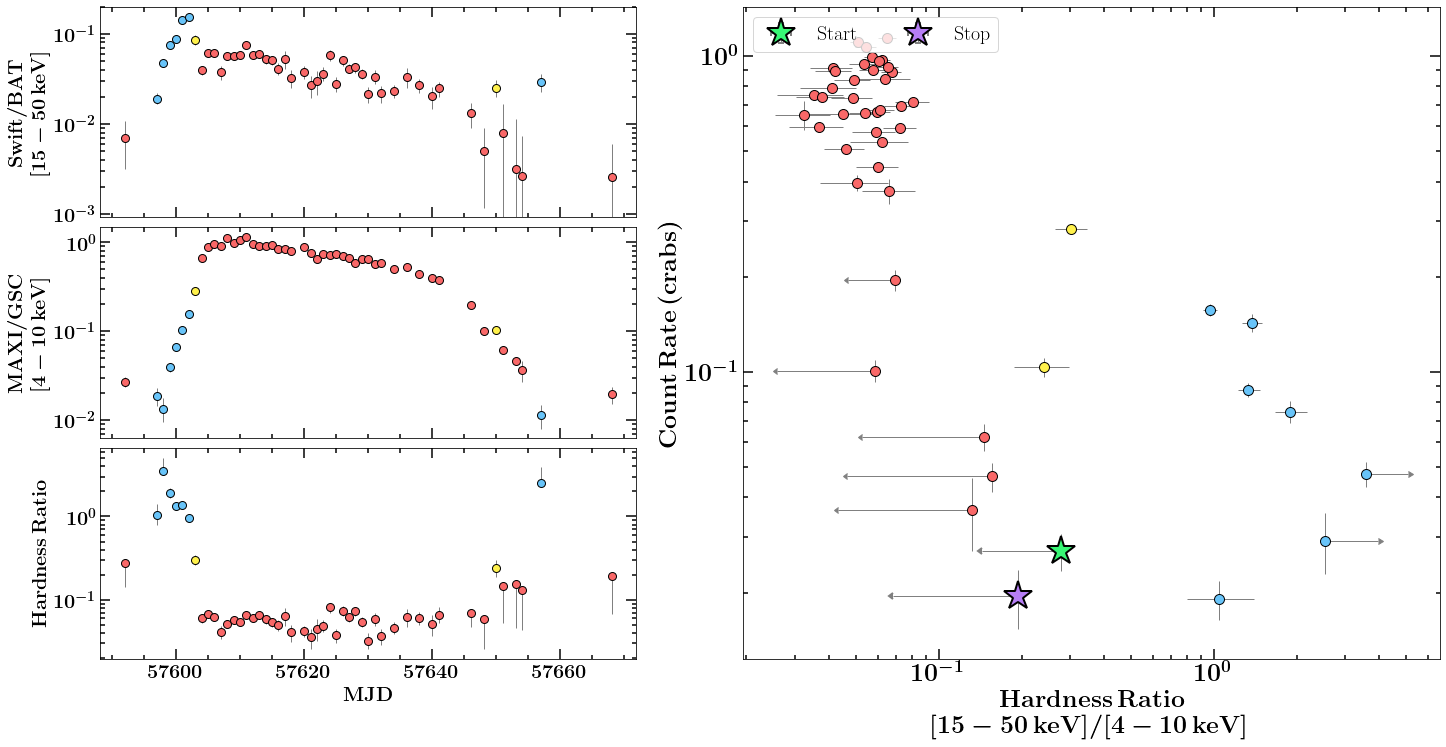

In [54]:
# step 6: plot figs 
# colour coded by accretion state: hard (blue), intermediate (yellow), soft (red)

# Bright outburst 1 
tb = 57580
te = 57700

# Bright outburst 2
#tb = 59500
#te = 60000

#################
# EDIT THIS:
#tb=57600 #start time
#te=58000 #end time
lineFlag=False #connect HID points?
################
time_list=[tb,te]
plot_data(source1,time_list,lineFlag,'SM', '')
#plot_data(source1,time_list,lineFlag,'SM', '_all')